In [1]:
import pandas as pd

df = pd.read_csv("../data/processed/weather_clean.csv")



Global temperature trend

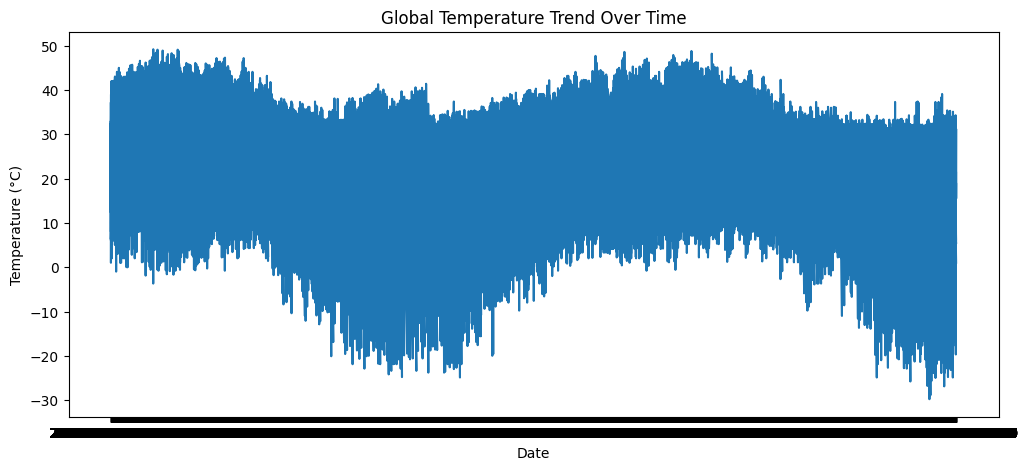

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df['last_updated'], df['temperature_celsius'])
plt.title("Global Temperature Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()


Precipitation trend

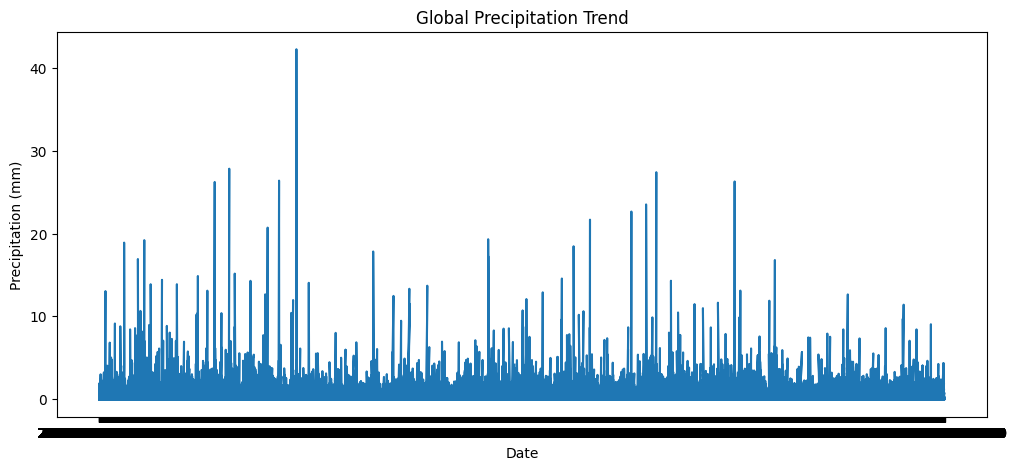

In [3]:
plt.figure(figsize=(12,5))
plt.plot(df['last_updated'], df['precip_mm'])
plt.title("Global Precipitation Trend")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.show()


Top 10 hottest countries

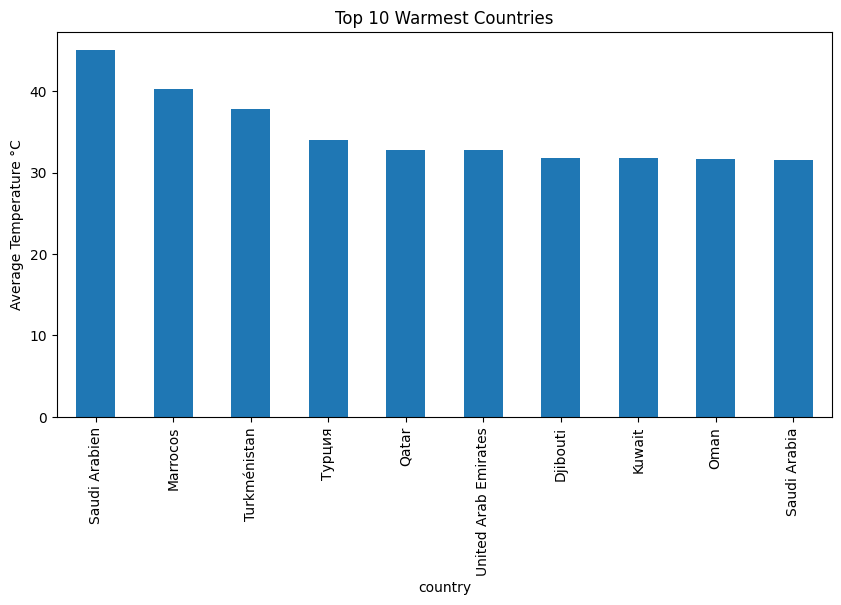

In [4]:
top_countries = (
    df.groupby('country')['temperature_celsius']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

top_countries.plot(kind='bar', figsize=(10,5))
plt.title("Top 10 Warmest Countries")
plt.ylabel("Average Temperature °C")
plt.show()


Top 10 coldest countries

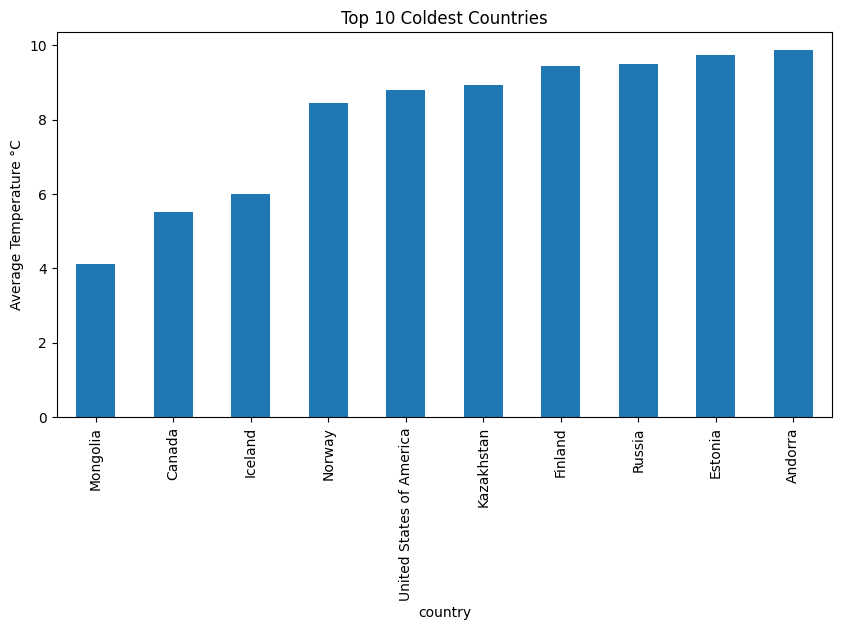

In [5]:
cold_countries = (
    df.groupby('country')['temperature_celsius']
    .mean()
    .sort_values()
    .head(10)
)

cold_countries.plot(kind='bar', figsize=(10,5))
plt.title("Top 10 Coldest Countries")
plt.ylabel("Average Temperature °C")
plt.show()


Correlation Heatmap

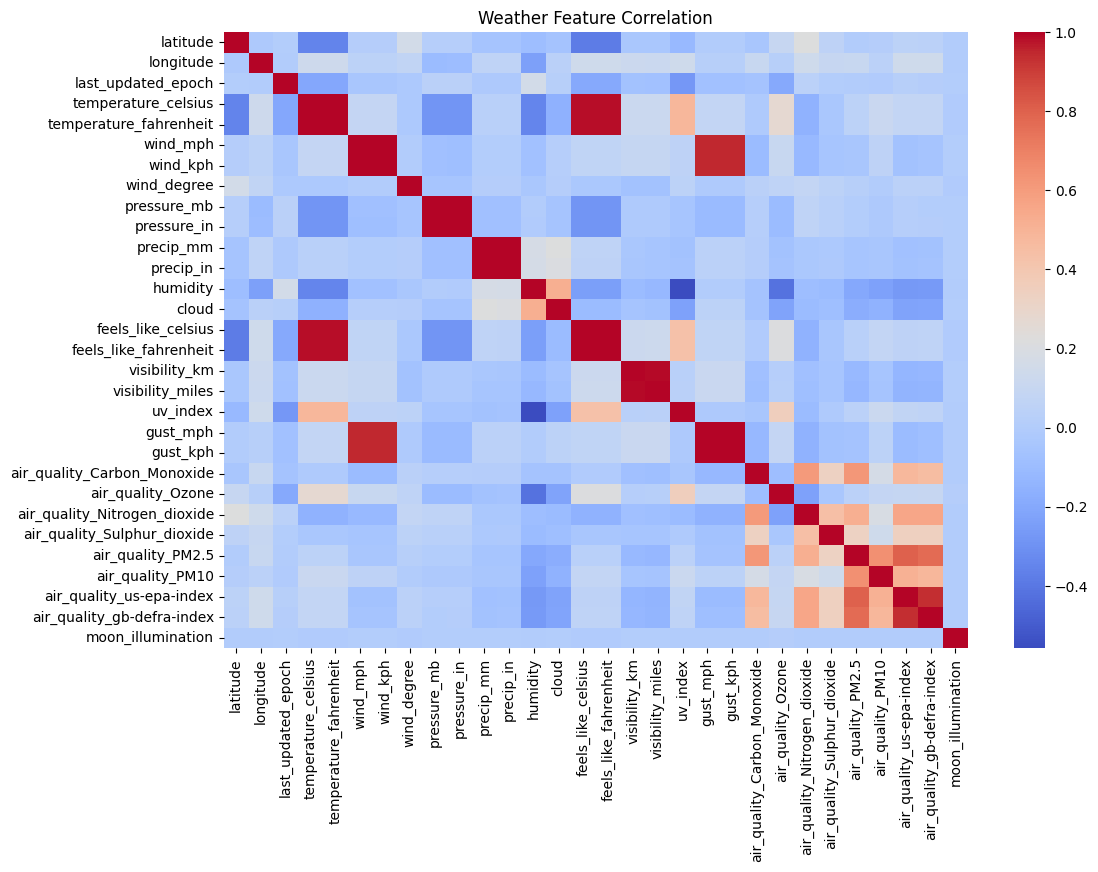

In [6]:
import seaborn as sns

plt.figure(figsize=(12,8))
sns.heatmap(df.select_dtypes(include='number').corr(), cmap='coolwarm')
plt.title("Weather Feature Correlation")
plt.show()


Monthly temperature pattern

In [7]:
df['last_updated'] = pd.to_datetime(df['last_updated'])


In [8]:
df['month'] = df['last_updated'].dt.month


In [9]:
print(df['last_updated'].dtype)


datetime64[ns]


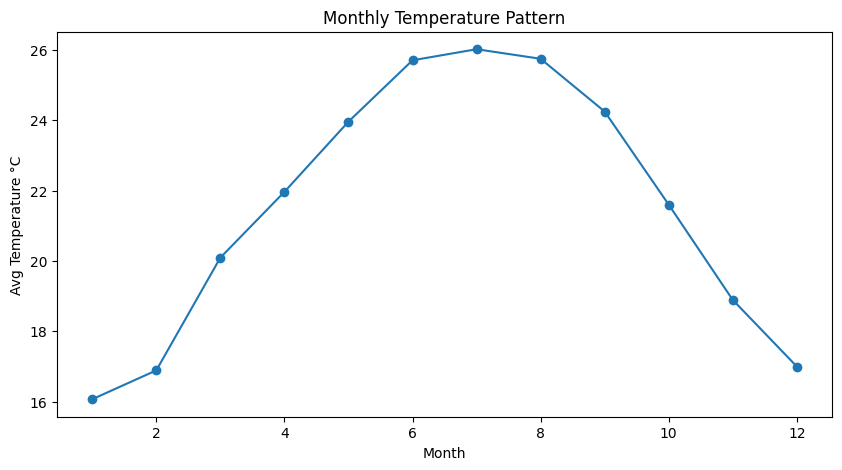

In [10]:
monthly_temp = df.groupby('month')['temperature_celsius'].mean()

monthly_temp.plot(marker='o', figsize=(10,5))
plt.title("Monthly Temperature Pattern")
plt.xlabel("Month")
plt.ylabel("Avg Temperature °C")
plt.show()


Anomaly detection

City used: Kabul
Anomalies found: 0


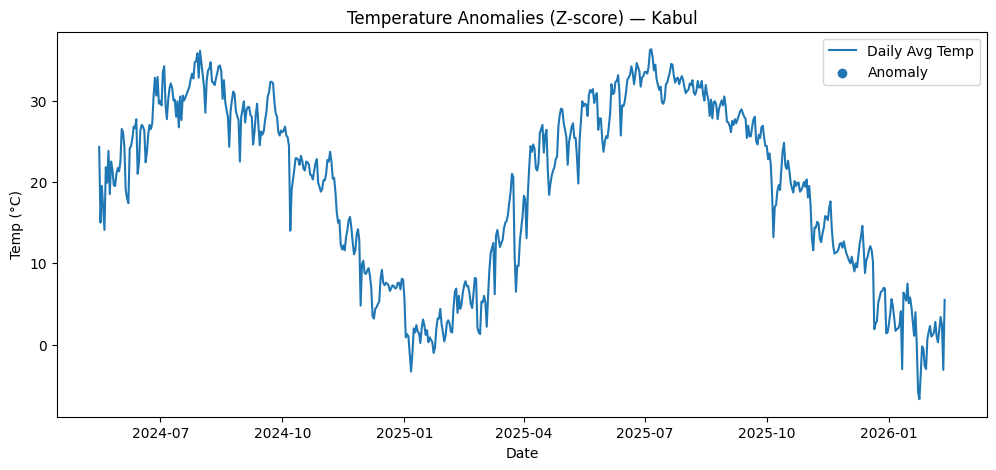

,temperature_celsius,z,is_anomaly
last_updated,,,


In [12]:
import numpy as np

# choose one location to make anomalies meaningful
city = df['location_name'].value_counts().index[0]   # most frequent city in data
city_df = df[df['location_name'] == city].copy()

city_df['last_updated'] = pd.to_datetime(city_df['last_updated'])
city_df = city_df.sort_values('last_updated')

# daily average temp (handles multiple entries per day)
daily = (city_df.set_index('last_updated')
         .resample('D')['temperature_celsius']
         .mean()
         .dropna()
         .to_frame())

# z-score anomaly detection
daily['z'] = (daily['temperature_celsius'] - daily['temperature_celsius'].mean()) / daily['temperature_celsius'].std()
daily['is_anomaly'] = daily['z'].abs() > 3

print("City used:", city)
print("Anomalies found:", daily['is_anomaly'].sum())

import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(daily.index, daily['temperature_celsius'], label='Daily Avg Temp')
plt.scatter(daily.index[daily['is_anomaly']], daily.loc[daily['is_anomaly'], 'temperature_celsius'], label='Anomaly')
plt.title(f"Temperature Anomalies (Z-score) — {city}")
plt.xlabel("Date"); plt.ylabel("Temp (°C)")
plt.legend()
plt.show()

daily[daily['is_anomaly']].head(10)


Air quality correlation

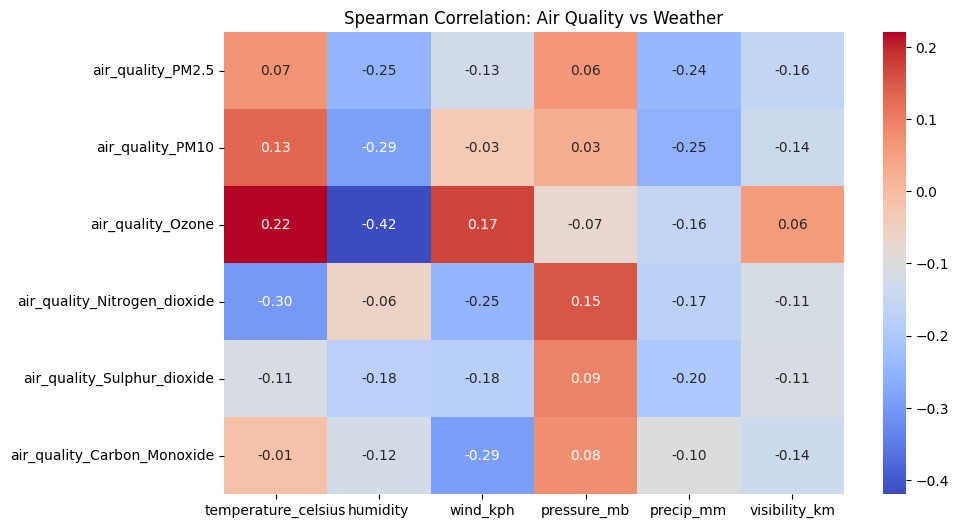

In [13]:
aq_cols = [
    'air_quality_PM2.5','air_quality_PM10',
    'air_quality_Ozone','air_quality_Nitrogen_dioxide',
    'air_quality_Sulphur_dioxide','air_quality_Carbon_Monoxide'
]
aq_cols = [c for c in aq_cols if c in df.columns]

weather_cols = ['temperature_celsius','humidity','wind_kph','pressure_mb','precip_mm','visibility_km']
weather_cols = [c for c in weather_cols if c in df.columns]

corr = df[aq_cols + weather_cols].corr(method='spearman')

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(corr.loc[aq_cols, weather_cols], annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Spearman Correlation: Air Quality vs Weather")
plt.show()


Spatial analysis

In [14]:
import plotly.express as px
import pandas as pd

df['last_updated'] = pd.to_datetime(df['last_updated'])

# take latest record per location (clean map snapshot)
latest = (df.sort_values('last_updated')
            .groupby(['country','location_name','latitude','longitude'], as_index=False)
            .tail(1))

fig = px.scatter_geo(
    latest,
    lat='latitude',
    lon='longitude',
    color='temperature_celsius',
    hover_name='location_name',
    hover_data=['country','humidity','precip_mm'],
    title="Latest Temperature by Location (Global)"
)
fig.show()
